# Detecting Communities in the Reddit Hyperlink Dataset
## For ECMM447 - Social Networks and Text Analysis



In [4]:
# Only run once to install necessary dependencies
!pip install scikit-image

In [46]:
import numpy as np
from collections import Counter

# Pandas Imports
import pandas
import pandas as pd

# Matplotlib Imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

# NetworkX Imports
import networkx as nx
from networkx.algorithms import community as comm

# Imports for Downloading TSV
import urllib.request as req
import os.path as path

# Datashader Imports
import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import circular_layout, forceatlas2_layout
from datashader.bundling import directly_connect_edges, hammer_bundle
from datashader.utils import export_image

In [12]:
# Downloads the Reddit Hyperlink dataset TSV file and saves it to ./data/
url = 'https://snap.stanford.edu/data/soc-redditHyperlinks-body.tsv'
body_save = "./data/soc-redditHyperlinks-body.tsv"
print("Checking for 'soc-redditHyperlinks-body.tsv'...")
if not path.exists(body_save):
    print("File not Found.")
    print(f"Downloading 'soc-redditHyperlinks-body.tsv' from URL: '{url}'...")
    req.urlretrieve(url, body_save)
else:
    print(f"Found at Path: '{body_save}'!")

url = 'https://snap.stanford.edu/data/soc-redditHyperlinks-title.tsv'
title_save = "./data/soc-redditHyperlinks-title.tsv"
print("Checking for 'soc-redditHyperlinks-title.tsv'...")
if not path.exists(title_save):
    print("File not Found.")
    print(f"Downloading 'soc-redditHyperlinks-title.tsv' from URL: '{url}'...")
    req.urlretrieve(url, title_save)
    print("Done!")
else:
    print(f"Found at Path: '{title_save}'!")
    
title_path = title_save
body_path = body_save

# Load the TSV files and convert to CSV files
title_df = pd.read_table(title_path, sep="\t")
title_csv = title_path[:-4] + ".csv"
print(f"Converting TSV to CSV file at: '{title_csv}'...")
title_df.to_csv(title_csv)
print("Converted!")

body_df = pd.read_table(body_path, sep='\t')
body_csv = body_path[:-4] + ".csv"
print(f"Converting TSV to CSV file at: '{body_csv}'...")
body_df.to_csv(body_csv)
print("Converted!")

# Load CSV files into DataFrames, concatenate them and extract Source/Target nodes
body_df = pd.read_csv(body_csv)
title_df = pd.read_csv(title_csv)

print("Creating edgelist DataFrame...")
reddit_df = pd.concat([title_df, body_df]).reset_index(drop=True)
reddit_df = reddit_df[["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"]]

reddit_df = reddit_df.groupby(["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT"]).size().reset_index(name='WEIGHT')
print("Done!")

reddit_path = "./data/redditHyperlinks-subredditsOnly.csv"
print(f"Saving edge details to CSV file at: '{reddit_path}'...")
reddit_df.to_csv(reddit_path, index=False)
print("Saved!")

Checking for 'soc-redditHyperlinks-body.tsv'...
Found at Path: './data/soc-redditHyperlinks-body.tsv'!
Checking for 'soc-redditHyperlinks-title.tsv'...
Found at Path: './data/soc-redditHyperlinks-title.tsv'!
Converting TSV to CSV file at: './data/soc-redditHyperlinks-title.csv'...
Converted!
Converting TSV to CSV file at: './data/soc-redditHyperlinks-body.csv'...
Converted!
Creating edgelist DataFrame...
Done!
Saving edge details to CSV file at: './data/redditHyperlinks-subredditsOnly.csv'...
Saved!


The following function loads a CSV file into a DataFrame.

In [8]:
def load_df(path):
    df = pd.read_csv(path)
    return df

Next, I load the subreddit edgelist into a dataframe. All graphs will be made from `reddit_df` or a subset of it.

In [13]:
reddit_csv = "./data/redditHyperlinks-subredditsOnly.csv"
reddit_df = load_df(reddit_csv)

print(reddit_df.columns)

Index(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'WEIGHT'], dtype='object')


The following function is a helper function that plots the nodes of a network via Datashader.

In [14]:
def nodes_plot(nodes, name=None, canvas=None, cat=None):
    # Create Datashader Canvas
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    
    # Create node aggregator
    aggregator = None if cat is None else ds.count_cat(cat)
    agg = canvas.points(nodes, 'x', 'y', aggregator)
    
    # Return shaded nodes
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

The following function plots the edges of a network via Datashader

In [15]:
def edges_plot(edges, name=None, canvas=None):
    # Create Datashader Canvas
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    
    # Return shaded edges
    return tf.shade(canvas.line(edges, 'x', 'y', agg=ds.count()), name=name)

The following function plots the nodes and edges combined

In [16]:
def graph_plot(nodes, edges, name="", canvas=None, cat=None):
    # Create the Canvas to draw on
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)

    # Plot the nodes
    np = nodes_plot(nodes, name + " nodes", canvas, cat)
    
    # Plot the edges
    ep = edges_plot(edges, name + " edges", canvas)
    
    # Return both nodes and edges shaded over one another
    return tf.stack(ep, np, how="over", name=name)

Now, perform some formatting to allow the nodes and edges to be displayed by the `graph_plot()` function.

In [27]:
# Create a list of unique subreddits
unique = pd.concat([reddit_df["SOURCE_SUBREDDIT"], reddit_df["TARGET_SUBREDDIT"]]).unique()

# Create a list of nodes
nodes = pd.DataFrame({'name': unique})

# Create a dictionary of node name to index in nodes
nodes_dict = {name: idx for idx, name in enumerate(nodes['name'])}

# Create list of edges by mapping nodes_dict over reddit_df
edges = reddit_df.copy()
edges['source'] = edges["SOURCE_SUBREDDIT"].map(nodes_dict)
edges['target'] = edges["TARGET_SUBREDDIT"].map(nodes_dict)
edges['weight'] = edges['WEIGHT']
edges.drop(columns=["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT", "WEIGHT"], inplace=True)

print(nodes.head)
print(edges.head)

<bound method NDFrame.head of                      name
0                     007
1                 07scape
2           07thexpansion
3        098f6bcd4621d373
4              0________0
...                   ...
67175  radiotransmissions
67176        islandparkny
67177  pogolithearthsound
67178           ifukmydog
67179            zistopia

[67180 rows x 1 columns]>
<bound method NDFrame.head of         source  target  weight
0            0   55863       1
1            1   34580       2
2            2   53031       1
3            3    3289       1
4            4   49828       1
...        ...     ...     ...
339638   55860   49449       1
339639   55861    6316       1
339640   55861   17220       1
339641   55861   19663       1
339642   55862   49953       1

[339643 rows x 3 columns]>


Next I plot the network in a Circular layout and using the ForceAtlas2 algorithm.

In [29]:
# Run this once to calculate the position of the nodes in both layouts.
# The ForceAtlas2 Algorithm takes a long time for the entire network.
# For example, when testing it took 28 minutes on a 32GB machine.
%time cd = circular_layout(nodes, uniform=False)
%time fd = forceatlas2_layout(nodes, edges)

CPU times: total: 0 ns
Wall time: 4.46 ms
CPU times: total: 28min 47s
Wall time: 28min 52s


Define some Canvas properties.

In [31]:
cvsopts = dict(plot_height=1200, plot_width=1200)

Create the plots. In this case, create a directly-connected graph for both Circular and Force-Directed as well as Bundled Edge graphs.

In [33]:
# Plot directly connected edge versions
%time cd_n = graph_plot(cd, directly_connect_edges(cd, edges), "Circular Layout")
%time fd_n = graph_plot(fd, directly_connect_edges(fd, edges), "Force-Directed Layout")

# Also plot bundled edge versions
%time cd_b = graph_plot(cd, hammer_bundle(cd, edges, weight='weight'), "Bundled Circular Layout")
%time fd_b = graph_plot(fd, hammer_bundle(fd, edges, weight='weight'), "Bundled Force-Directed Layout")

CPU times: total: 36.4 s
Wall time: 21.4 s
CPU times: total: 1.77 s
Wall time: 1.76 s
CPU times: total: 28min 43s
Wall time: 13min 5s
CPU times: total: 7min 2s
Wall time: 4min 34s



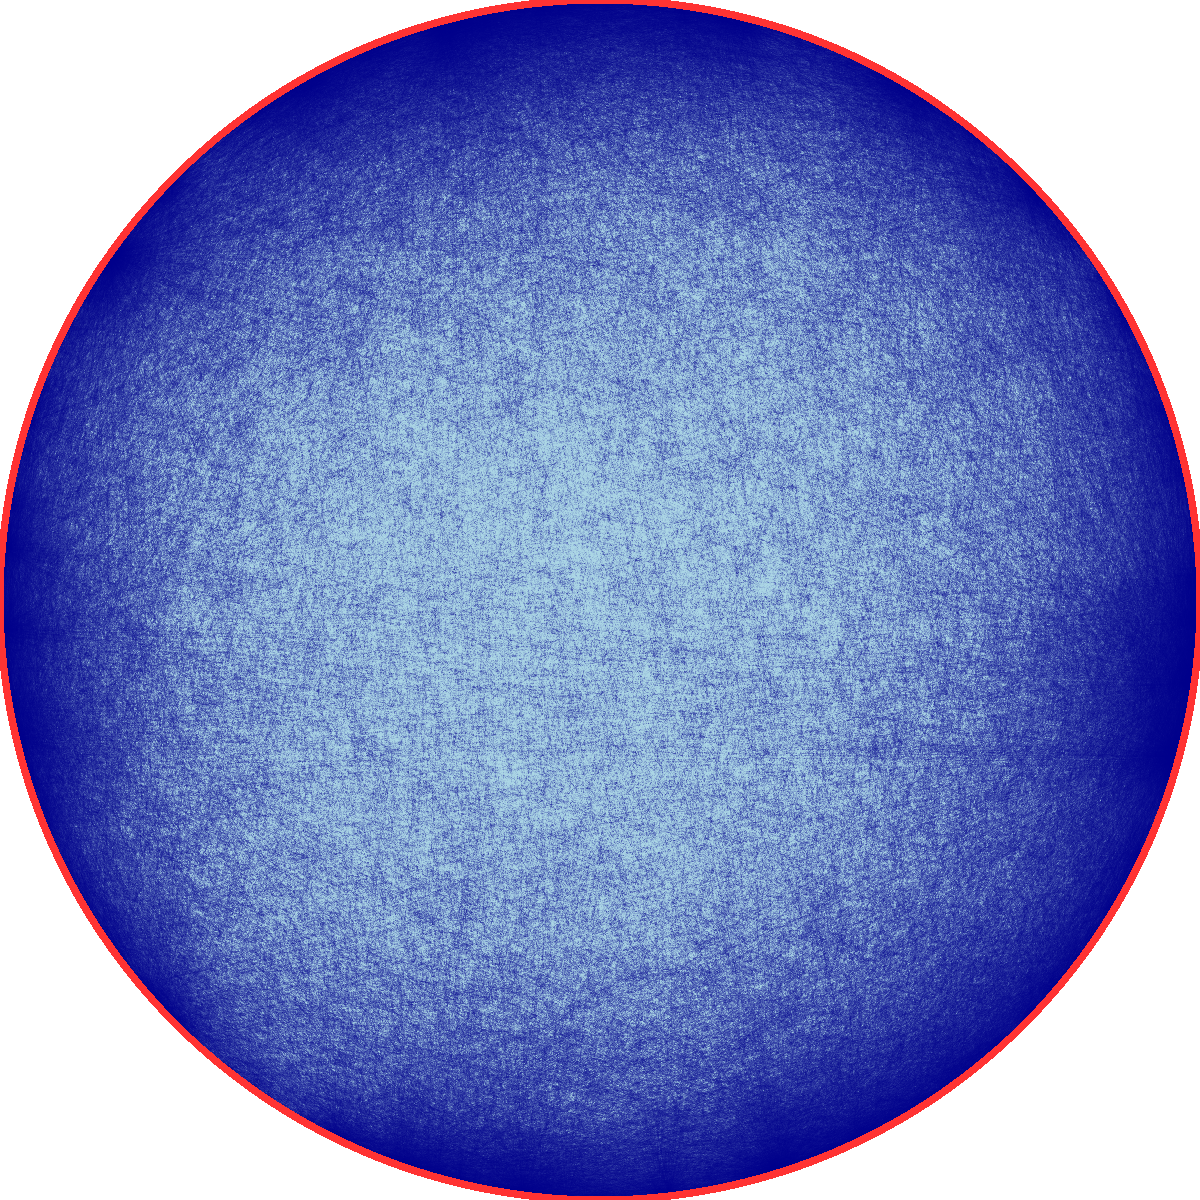
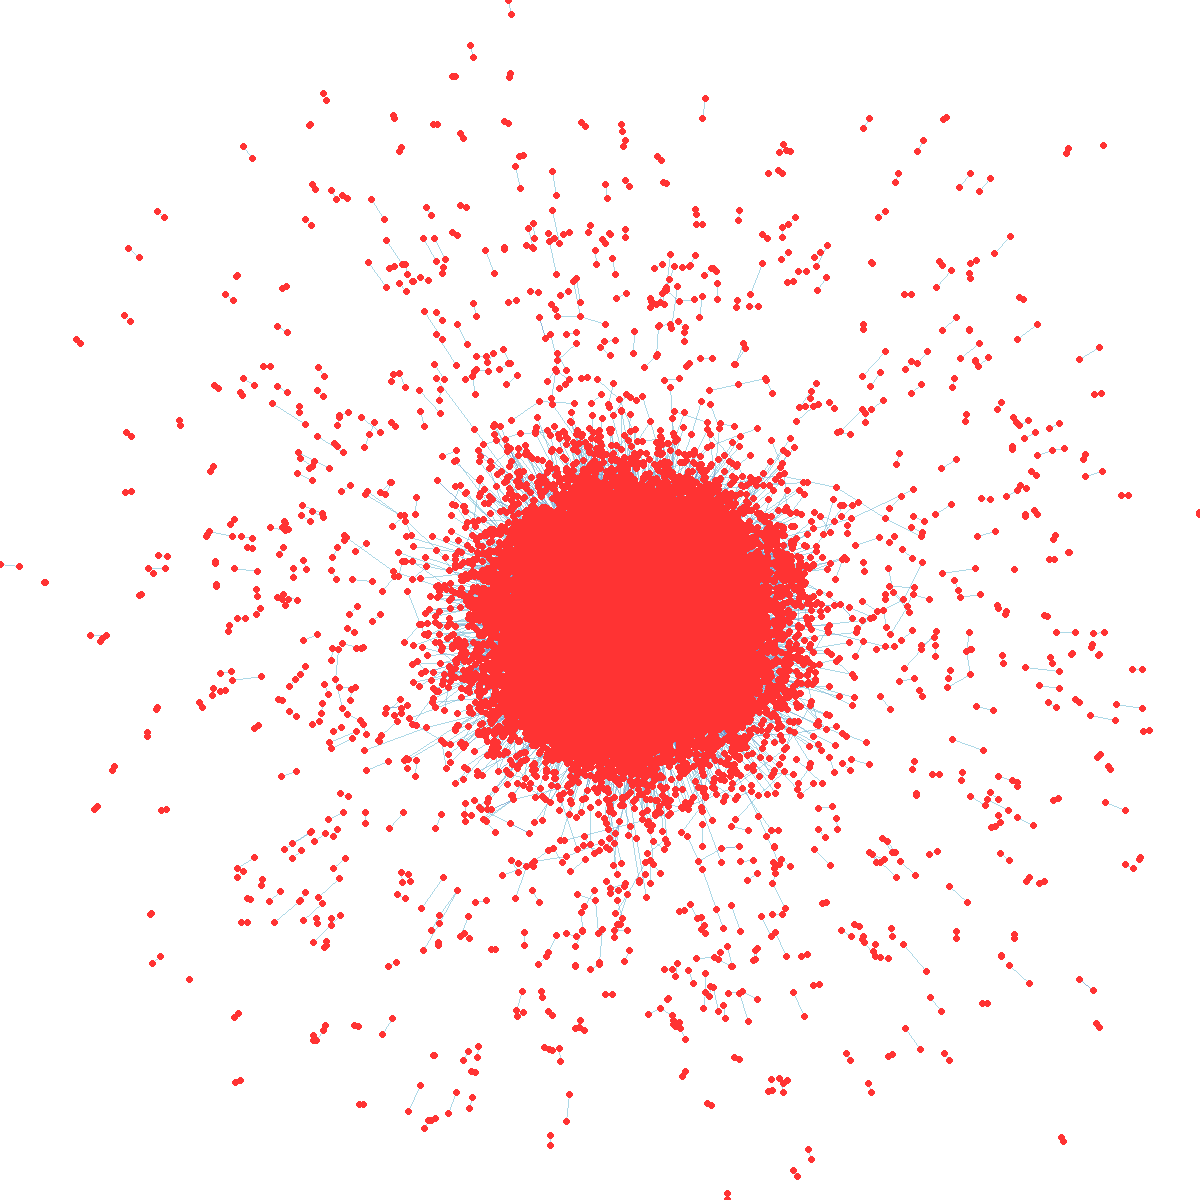
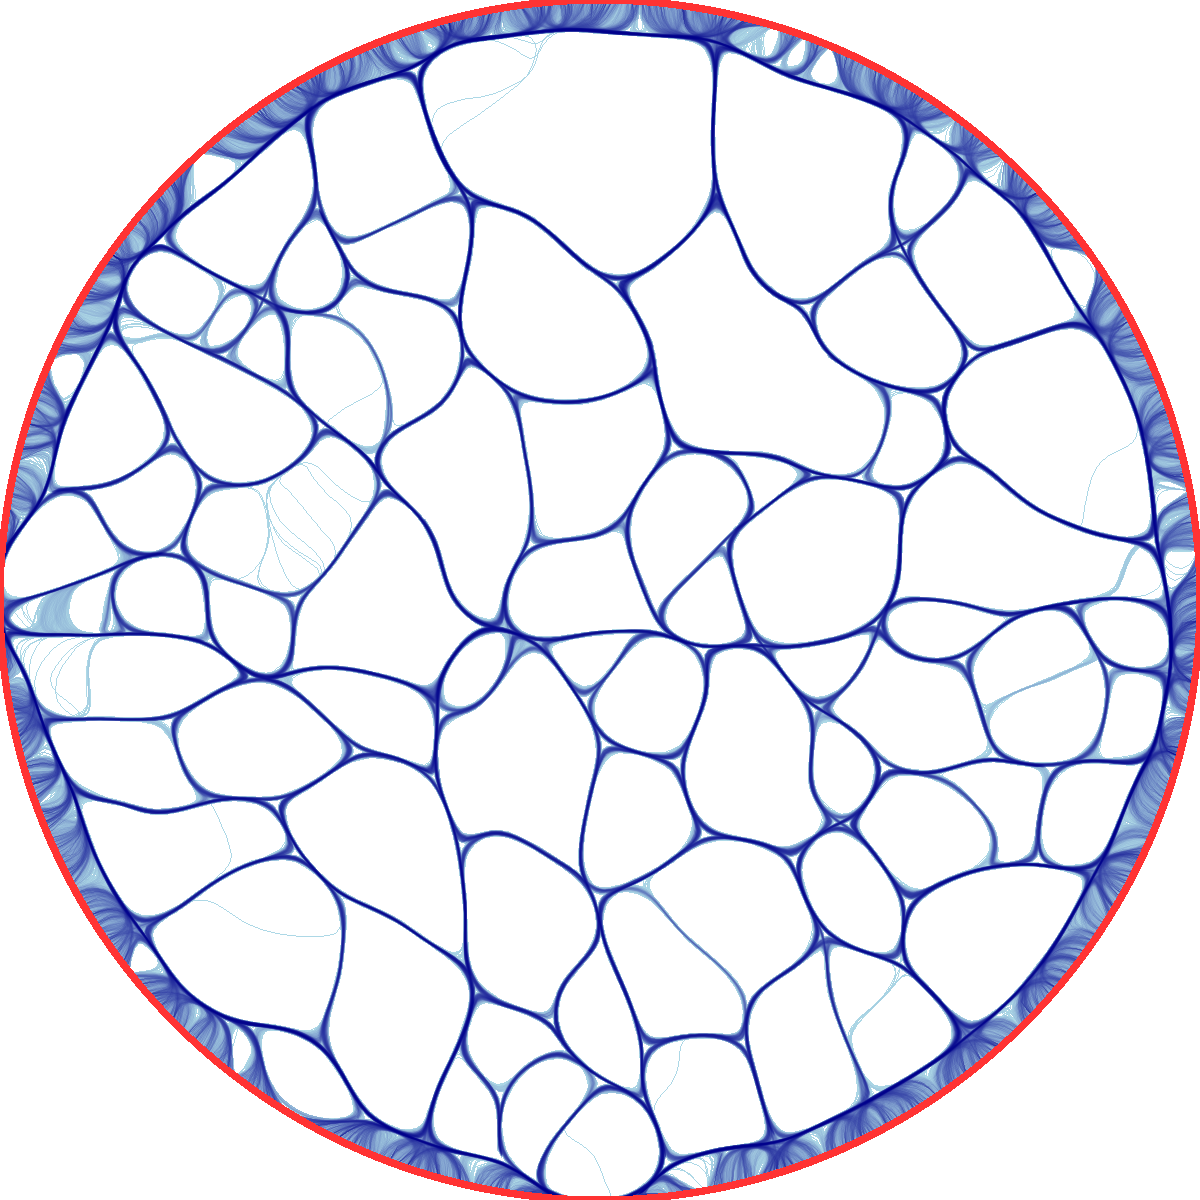
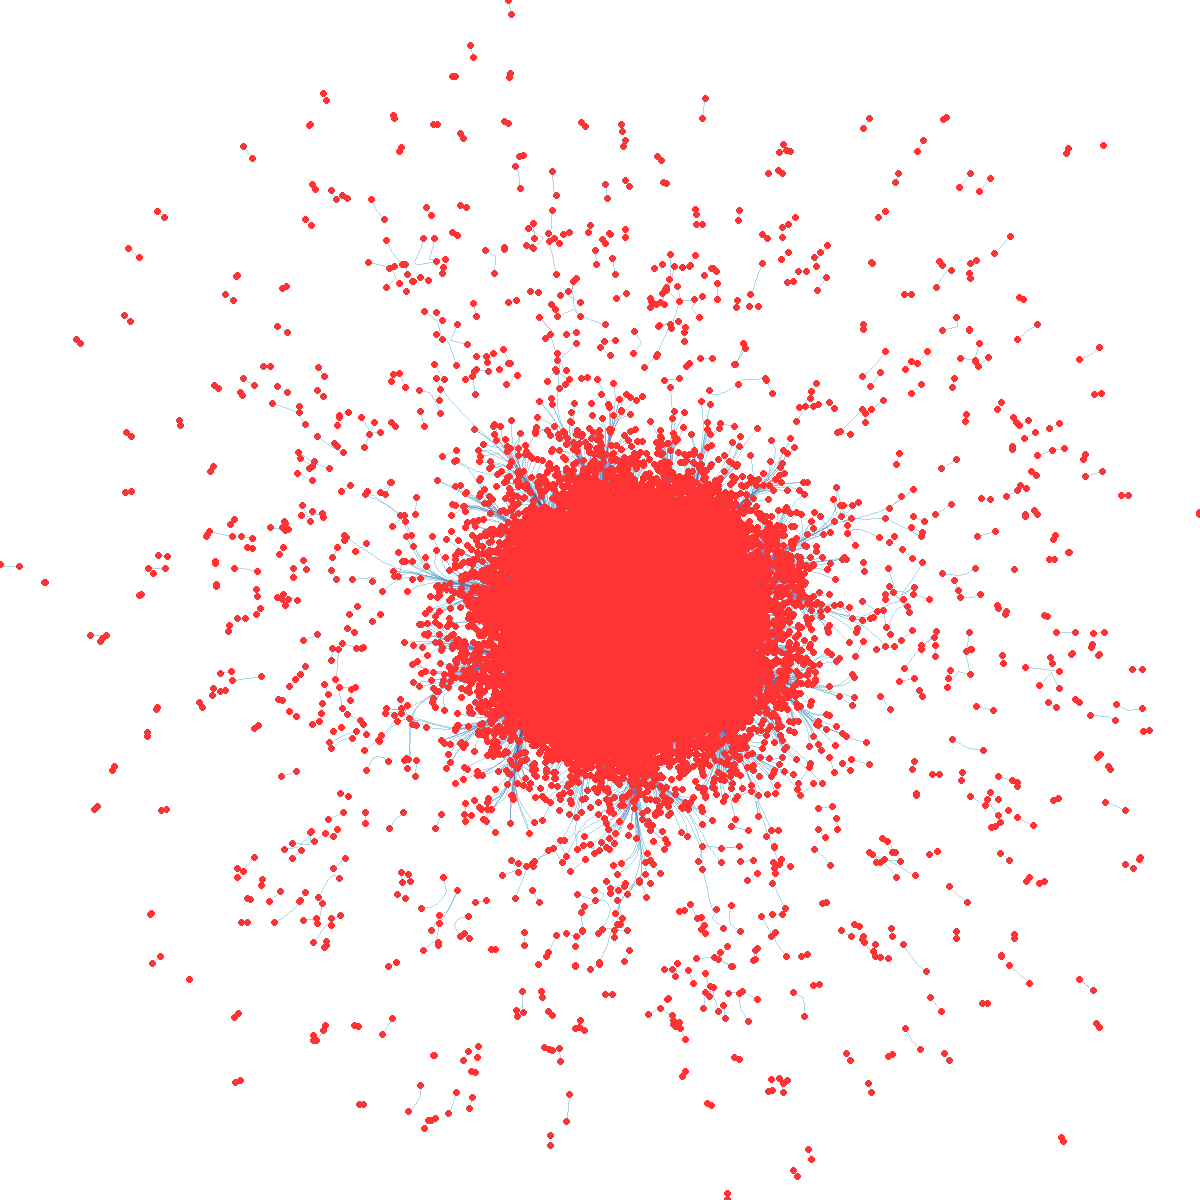

In [34]:
# Display images
tf.Images(cd_n, fd_n, cd_b, fd_b).cols(2)

As can be seen form the Force-Directed layout, there are many disjoint components which do not connect to the main network of subreddits. These could be considered as very small communities in themselves. There is an evident, large central mass of subreddits, which are all interconnected.

In terms of the Circular layout, there are not any visible or clearly defined communities evident, although it is clear from the thick edges found in the Bundled representation that subreddits tend to connect to one another via key nodes.

As there are many disconnected components, the Louvain algorithm can be sped up by remove these disconnected components before computation so that they do not need to be evaluated.

In [39]:
# Create Weighted Graph
weighted = nx.from_pandas_edgelist(edges, 'source', 'target', ['weight'])
print(f"Number of Nodes: {nx.number_of_nodes(weighted)}")

Number of Nodes: 67180


To evaluate the amount of trimming necessary, create a histogram showing the size of all connected components in the dataset.

CPU times: total: 93.8 ms
Wall time: 93.7 ms
There are 712 connected components.


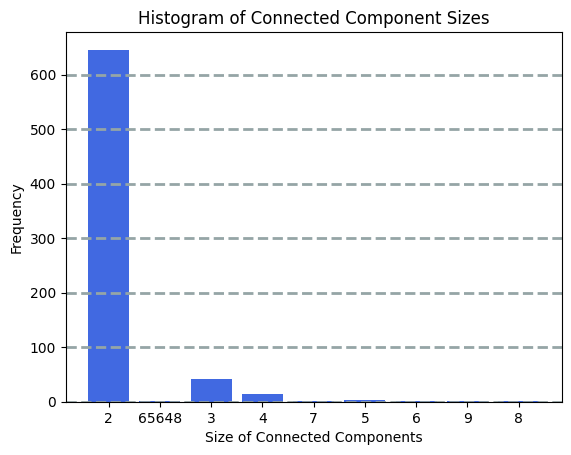

There are 646 components that contain 2 nodes.
There is 1 component that contains 65648 nodes.
There are 42 components that contain 3 nodes.
There are 14 components that contain 4 nodes.
There are 2 components that contain 7 nodes.
There are 3 components that contain 5 nodes.
There are 2 components that contain 6 nodes.
There is 1 component that contains 9 nodes.
There is 1 component that contains 8 nodes.


In [53]:
# Get all connected components
%time connected_components = list(nx.connected_components(weighted))
print(f"There are {len(connected_components)} connected components.")

# Get sizes of connected components
component_sizes = [len(c) for c in connected_components]
size_counts = Counter(component_sizes)

size_labels = size_counts.keys()

# Plot histogram
plt.xticks(range(len(size_counts.values())), size_labels)
plt.xlabel('Size of Connected Components')
plt.ylabel('Frequency')
plt.title('Histogram of Connected Component Sizes')
plt.bar(range(len(size_counts.values())), size_counts.values(), color='royalblue')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y')
plt.show()

# Print list of actual numbers
for key, value in size_counts.items():
    if value == 1:
        print(f"There is {value} component that contains {key} nodes.")
    else:
        print(f"There are {value} components that contain {key} nodes.")

As can be seen from the histogram, there are 646 components of only 2 nodes, which can be immediately discarded. Going forwards, I will use the single connected component containing 65648 nodes, as this contains enough nodes to apply community detection to.

In [59]:
# Get largest connected component
largest = max(connected_components, key=len)
%time largest = weighted.subgraph(largest)
print(f"Number of Nodes: {nx.number_of_nodes(largest)}")

CPU times: total: 15.6 ms
Wall time: 6.94 ms
Number of Nodes: 65648


Now plot the Circular and Force-Directed layouts again for the new, fully-connected network.

In [66]:
# Convert back into edgelist dataframe
%time connected_edges = nx.to_pandas_edgelist(largest)
print(f"Number of Edges: {len(connected_edges)}")
print(connected_edges.columns)

CPU times: total: 3.61 s
Wall time: 3.61 s
Number of Edges: 308839
Index(['source', 'target', 'weight'], dtype='object')


In [87]:
# Create a new node list for the large component
in_largest = nodes.index.isin(set(connected_edges['source']) | set(connected_edges['target']))
connected_nodes = nodes[in_largest]

print(connected_nodes.head)
print(connected_edges.head)

<bound method NDFrame.head of                      name
1                 07scape
2           07thexpansion
3        098f6bcd4621d373
4              0________0
5                 0magick
...                   ...
67175  radiotransmissions
67176        islandparkny
67177  pogolithearthsound
67178           ifukmydog
67179            zistopia

[65648 rows x 1 columns]>
<bound method NDFrame.head of         source  target  weight
0            1   34580       2
1            1     117       3
2        34580     117       4
3        34580   47740      10
4            2   53031       1
...        ...     ...     ...
308834   55729   67169       1
308835   55729   67170       1
308836   55729   67171       1
308837   55796   55850       1
308838   55798   55799       1

[308839 rows x 3 columns]>


In [90]:
# Calculate positions for the Circular and Force-Directed Layouts
# The ForceAtlas2 Algorithm takes a long time for the entire network.
# For example, when testing it took 31 minutes on a 32GB machine.
%time cd = circular_layout(connected_nodes, uniform=False)
%time fd = forceatlas2_layout(connected_nodes, edges)

CPU times: total: 31.2 ms
Wall time: 3.97 ms
CPU times: total: 32min 52s
Wall time: 33min 4s


In [91]:
# Plot directly connected edge versions
%time cd_n = graph_plot(cd, directly_connect_edges(cd, connected_edges), "Connected Circular Layout")
%time fd_n = graph_plot(fd, directly_connect_edges(fd, connected_edges), "Connected Force-Directed Layout")

# Also plot bundled edge versions
%time cd_b = graph_plot(cd, hammer_bundle(cd, connected_edges, weight='weight'), "Connected Bundled Circular Layout")
%time fd_b = graph_plot(fd, hammer_bundle(fd, connected_edges, weight='weight'), "Connected Bundled Force-Directed Layout")

CPU times: total: 2.64 s
Wall time: 2.66 s
CPU times: total: 1.64 s
Wall time: 1.63 s
CPU times: total: 26min 59s
Wall time: 12min 3s
CPU times: total: 8min 18s
Wall time: 5min 36s



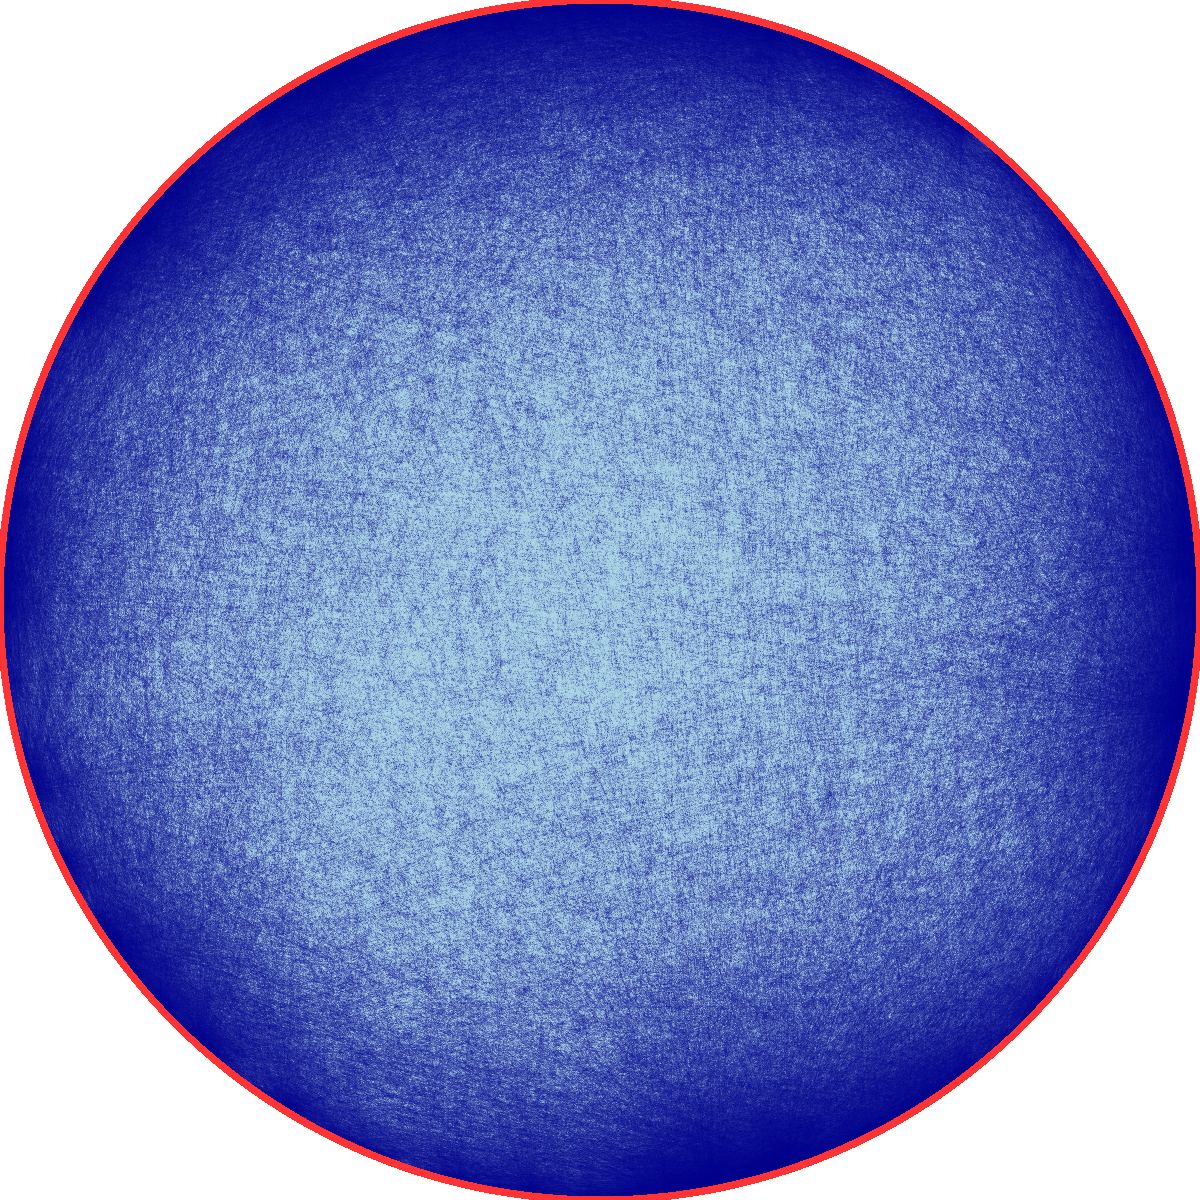
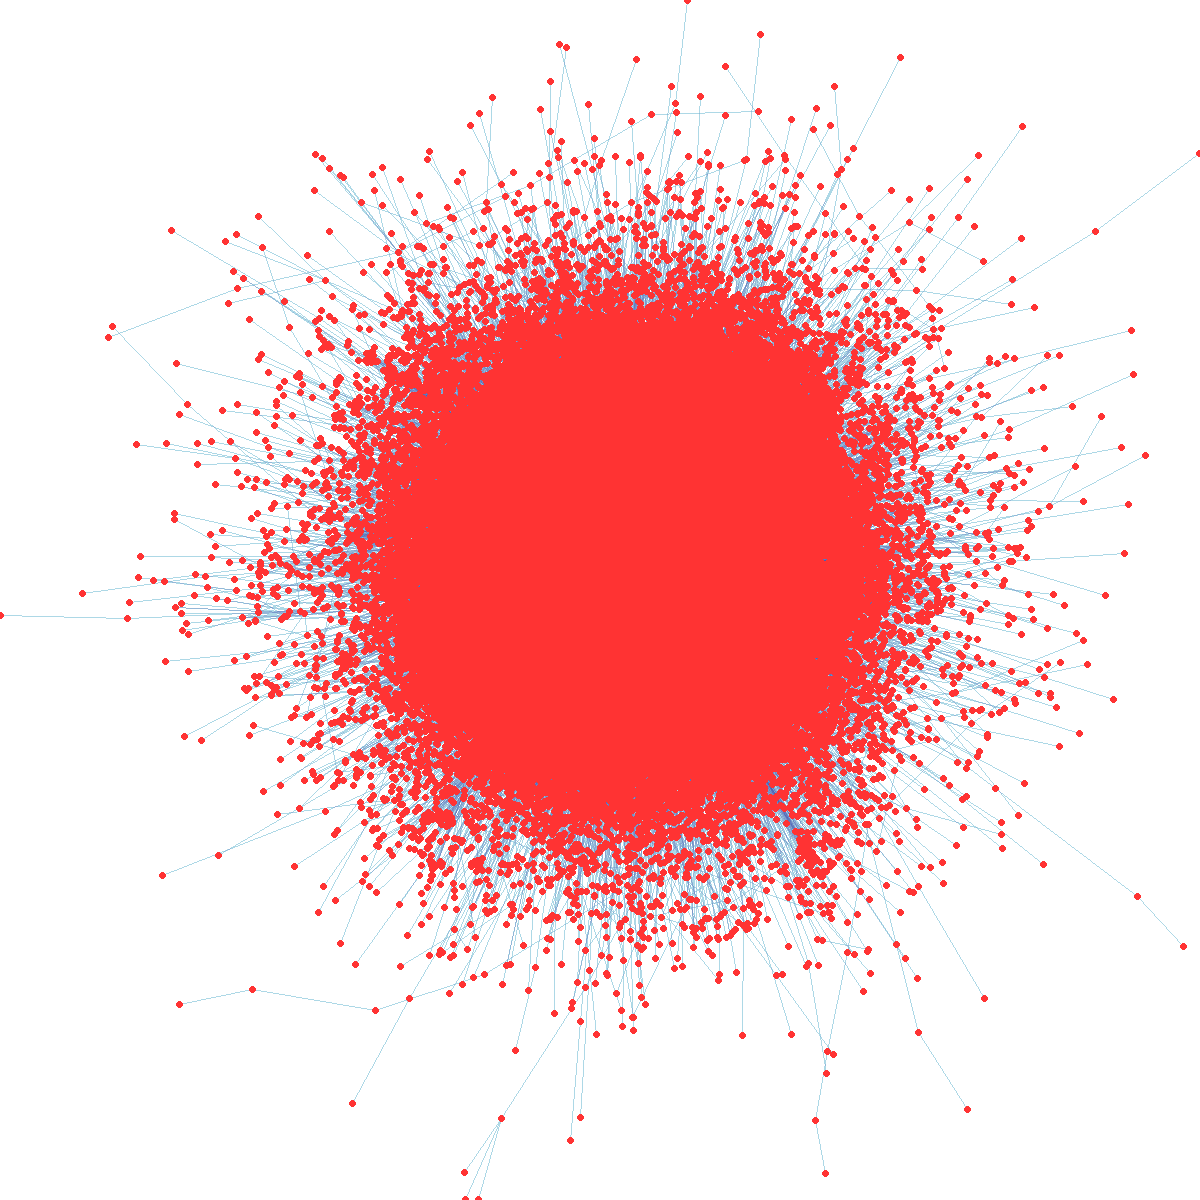
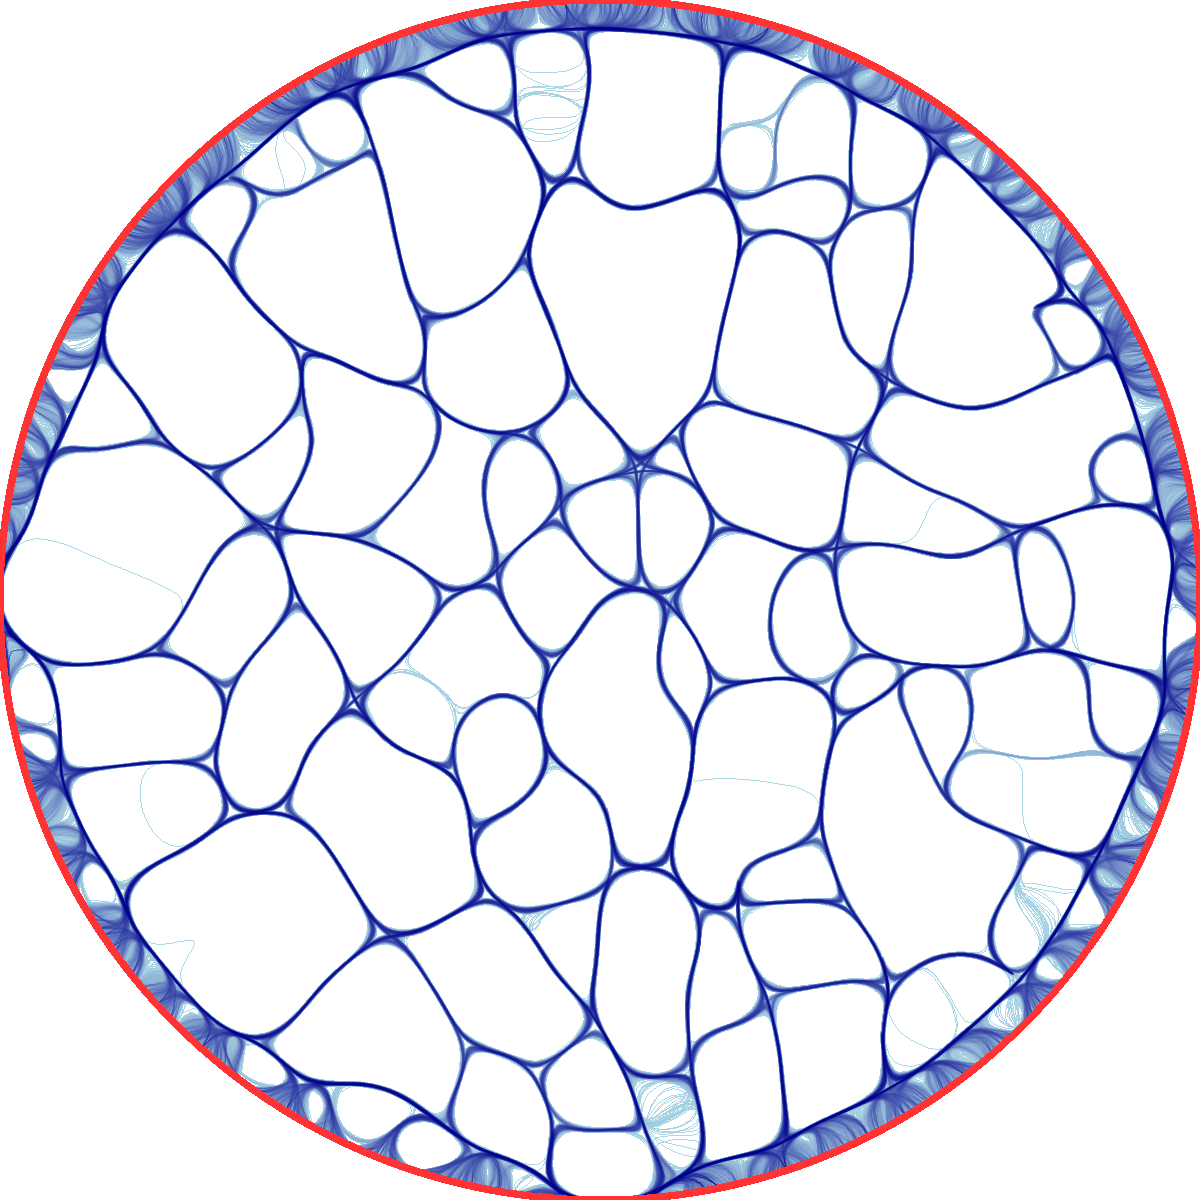
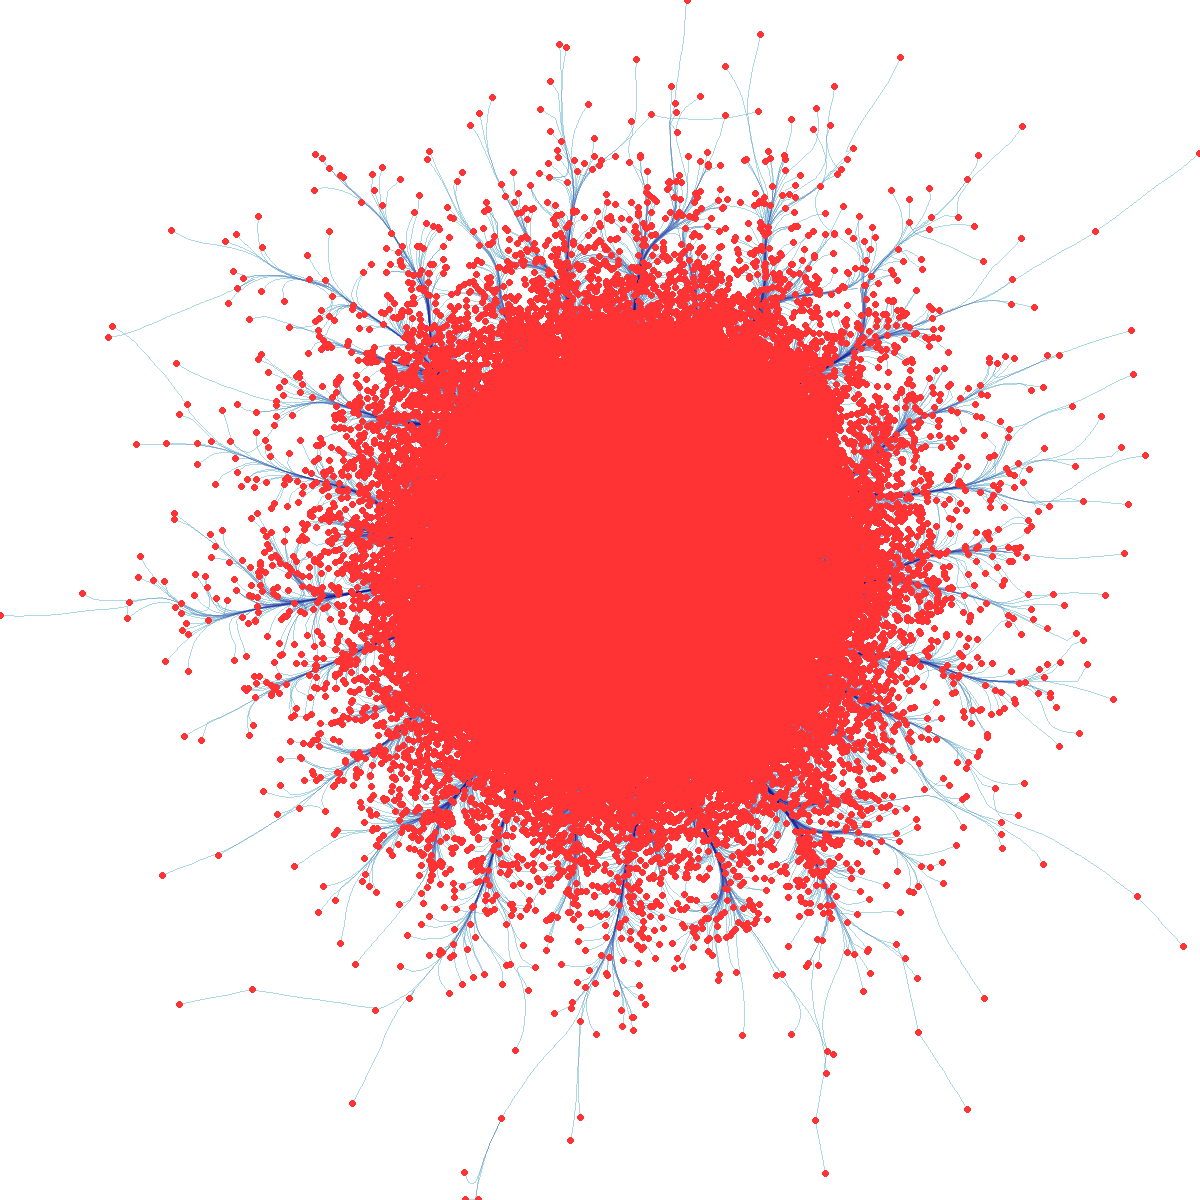

In [92]:
# Display images
tf.Images(cd_n, fd_n, cd_b, fd_b).cols(2)